<a href="https://colab.research.google.com/github/AashuSapkota/dog-breed-classification/blob/main/Dog_breed_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ============================================================================
# HIERARCHICAL DOG BREED CLASSIFICATION
# ============================================================================

# Import libraries
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import os
import datetime
import time

print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)
print("GPU", "available (YESSSS!!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

TF version: 2.19.0
TF Hub version: 0.16.1
GPU available (YESSSS!!!!!)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ============================================================================
# BREED TO AKC GROUP MAPPING (Derived from existing breed labels)
# ============================================================================

BREED_TO_GROUP = {
    # SPORTING GROUP (1)
    'golden_retriever': 'sporting', 'cocker_spaniel': 'sporting',
    'chesapeake_bay_retriever': 'sporting', 'brittany_spaniel': 'sporting',
    'english_setter': 'sporting', 'english_springer': 'sporting',
    'german_shorthaired': 'sporting', 'irish_setter': 'sporting',
    'irish_water_spaniel': 'sporting', 'welsh_springer_spaniel': 'sporting',
    'clumber': 'sporting', 'sussex_spaniel': 'sporting',

    # HOUND GROUP (2)
    'beagle': 'hound', 'bloodhound': 'hound', 'bluetick': 'hound',
    'redbone': 'hound', 'walker_hound': 'hound', 'english_foxhound': 'hound',
    'basset': 'hound', 'black-and-tan_coonhound': 'hound',
    'afghan_hound': 'hound', 'borzoi': 'hound', 'saluki': 'hound',
    'scottish_deerhound': 'hound', 'whippet': 'hound', 'ibizan_hound': 'hound',
    'irish_wolfhound': 'hound', 'norwegian_elkhound': 'hound',
    'otterhound': 'hound', 'rhodesian_ridgeback': 'hound',
    'dachshund': 'hound', 'basenji': 'hound',

    # WORKING GROUP (3)
    'boxer': 'working', 'doberman': 'working', 'great_dane': 'working',
    'rottweiler': 'working', 'saint_bernard': 'working', 'siberian_husky': 'working',
    'bull_mastiff': 'working', 'great_pyrenees': 'working',
    'greater_swiss_mountain_dog': 'working', 'bernese_mountain_dog': 'working',
    'newfoundland': 'working', 'portuguese_water_dog': 'working',
    'samoyed': 'working', 'malamute': 'working', 'eskimo_dog': 'working',
    'kuvasz': 'working', 'komondor': 'working', 'tibetan_mastiff': 'working',
    'akita': 'working', 'leonberg': 'working', 'giant_schnauzer': 'working',
    'standard_schnauzer': 'working',

    # TERRIER GROUP (4)
    'airedale': 'terrier', 'american_staffordshire_terrier': 'terrier',
    'australian_terrier': 'terrier', 'bedlington_terrier': 'terrier',
    'border_terrier': 'terrier', 'boston_bull': 'terrier',
    'bull_terrier': 'terrier', 'cairn': 'terrier',
    'dandie_dinmont': 'terrier', 'fox_terrier': 'terrier',
    'irish_terrier': 'terrier', 'kerry_blue_terrier': 'terrier',
    'lakeland_terrier': 'terrier', 'norfolk_terrier': 'terrier',
    'norwich_terrier': 'terrier', 'scotch_terrier': 'terrier',
    'sealyham_terrier': 'terrier', 'soft-coated_wheaten_terrier': 'terrier',
    'staffordshire_bullterrier': 'terrier', 'west_highland_white_terrier': 'terrier',
    'wire-haired_fox_terrier': 'terrier', 'yorkshire_terrier': 'terrier',
    'lakeland_terrier': 'terrier', 'miniature_schnauzer': 'terrier',
    'silky_terrier': 'terrier', 'toy_terrier': 'terrier',

    # TOY GROUP (5)
    'chihuahua': 'toy', 'pug': 'toy', 'pomeranian': 'toy',
    'pekinese': 'toy', 'papillon': 'toy', 'maltese_dog': 'toy',
    'toy_poodle': 'toy', 'shih-tzu': 'toy', 'japanese_spaniel': 'toy',
    'blenheim_spaniel': 'toy', 'miniature_pinscher': 'toy',
    'toy_terrier': 'toy', 'affenpinscher': 'toy', 'brabancon_griffon': 'toy',

    # NON-SPORTING GROUP (6)
    'french_bulldog': 'non-sporting', 'bulldog': 'non-sporting',
    'boston_bull': 'non-sporting', 'dalmatian': 'non-sporting',
    'chow': 'non-sporting', 'keeshond': 'non-sporting',
    'schipperke': 'non-sporting', 'poodle': 'non-sporting',
    'miniature_poodle': 'non-sporting', 'standard_poodle': 'non-sporting',
    'lhasa': 'non-sporting', 'tibetan_terrier': 'non-sporting',

    # HERDING GROUP (7)
    'german_shepherd': 'herding', 'collie': 'herding',
    'border_collie': 'herding', 'shetland_sheepdog': 'herding',
    'old_english_sheepdog': 'herding', 'cardigan': 'herding',
    'pembroke': 'herding', 'briard': 'herding',
    'kelpie': 'herding', 'komondor': 'herding',
    'groenendael': 'herding', 'malinois': 'herding',
    'appenzeller': 'herding', 'entlebucher': 'herding',
    'bouvier_des_flandres': 'herding',

    # MISCELLANEOUS (for breeds not in standard AKC groups)
    'mexican_hairless': 'non-sporting', 'dingo': 'hound',
    'african_hunting_dog': 'hound', 'dhole': 'hound',
}

# Group labels mapping
GROUP_LABELS = {
    'sporting': 0,
    'hound': 1,
    'working': 2,
    'terrier': 3,
    'toy': 4,
    'non-sporting': 5,
    'herding': 6
}

# Reverse mapping
GROUP_NAMES = {v: k for k, v in GROUP_LABELS.items()}

print(f"Total breed-to-group mappings: {len(BREED_TO_GROUP)}")
print(f"Total groups: {len(GROUP_LABELS)}")
print(f"Group distribution:\n{pd.Series(list(BREED_TO_GROUP.values())).value_counts()}")

Total breed-to-group mappings: 121
Total groups: 7
Group distribution:
hound           23
terrier         23
working         21
herding         15
toy             14
non-sporting    13
sporting        12
Name: count, dtype: int64


In [ ]:
# ============================================================================
# DATA LOADING AND PREPARATION
# ============================================================================

# Load labels
labels_csv = pd.read_csv("drive/My Drive/Dog Vision/labels.csv")
print(f"Total samples: {len(labels_csv)}")
print(labels_csv.head())

# Create filenames
filenames = ["drive/My Drive/Dog Vision/train/" + fname + ".jpg" for fname in labels_csv["id"]]

# Get breed labels
breed_labels = labels_csv["breed"].to_numpy()
unique_breeds = np.unique(breed_labels)
num_breeds = len(unique_breeds)

print(f"\nTotal unique breeds: {num_breeds}")

# Create group labels from breed labels
def get_group_label(breed):
    """Map breed to group label"""
    group_name = BREED_TO_GROUP.get(breed, 'non-sporting')  # default to non-sporting
    return GROUP_LABELS[group_name]

group_labels = np.array([get_group_label(breed) for breed in breed_labels])
unique_groups = np.unique(group_labels)
num_groups = len(unique_groups)

print(f"Total unique groups: {num_groups}")

# Create boolean labels for breeds
boolean_breed_labels = [label == unique_breeds for label in breed_labels]

# Create one-hot labels for groups
from tensorflow.keras.utils import to_categorical
onehot_group_labels = to_categorical(group_labels, num_classes=num_groups)

print(f"\nBreed label shape: {np.array(boolean_breed_labels).shape}")
print(f"Group label shape: {onehot_group_labels.shape}")

# Verify mapping
print("\nSample mappings:")
for i in range(5):
    breed = breed_labels[i]
    group_idx = group_labels[i]
    group_name = GROUP_NAMES[group_idx]
    print(f"{breed} -> {group_name}")

Total samples: 10222
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

Total unique breeds: 120
Total unique groups: 7

Breed label shape: (10222, 120)
Group label shape: (10222, 7)

Sample mappings:
boston_bull -> non-sporting
dingo -> hound
pekinese -> toy
bluetick -> hound
golden_retriever -> sporting


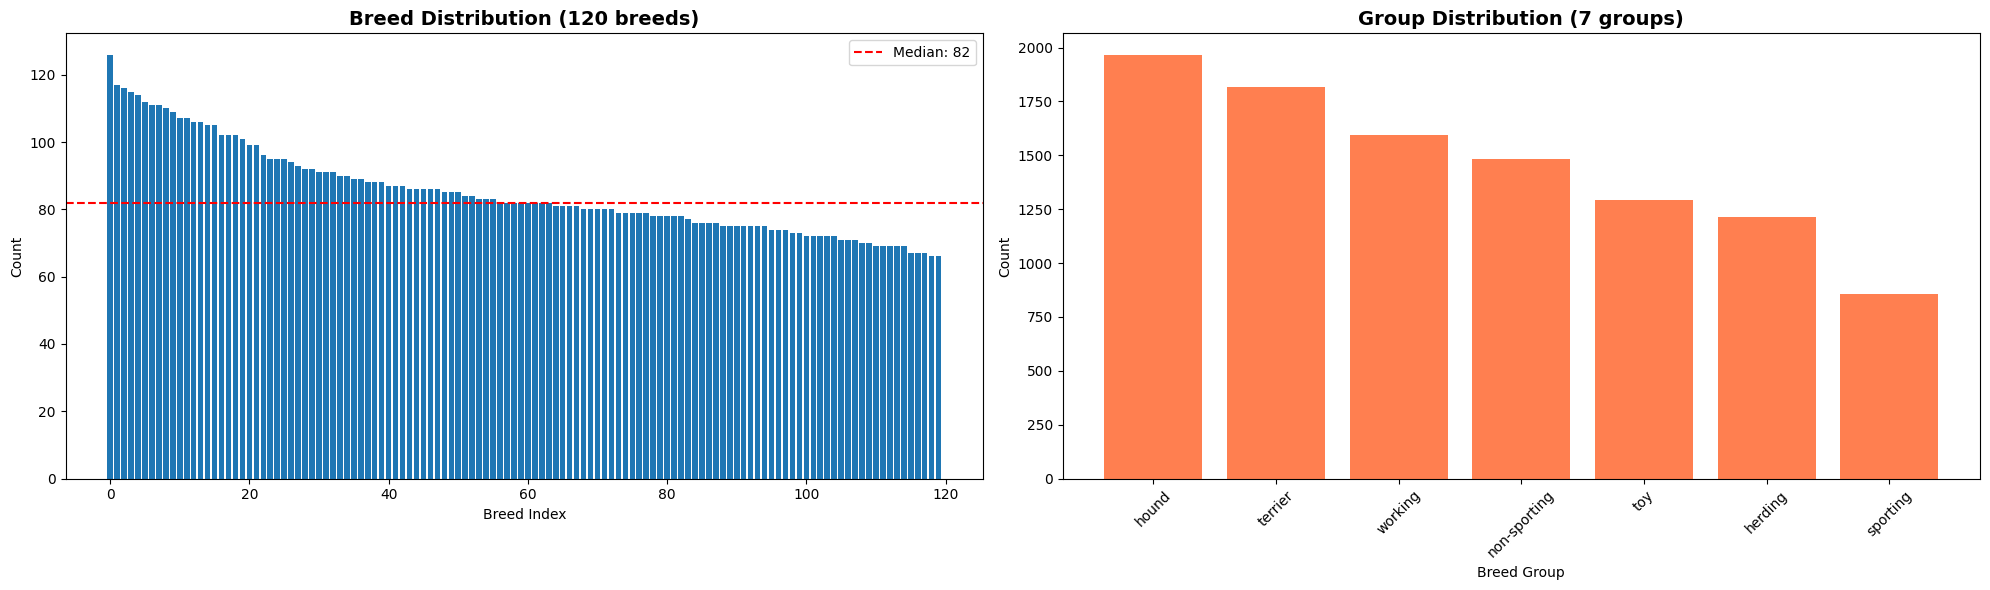


Breed statistics:
Mean samples per breed: 85.2
Median samples per breed: 82.0
Min samples: 66, Max samples: 126

Group statistics:
hound           1968
terrier         1815
working         1595
non-sporting    1483
toy             1291
herding         1212
sporting         858
Name: count, dtype: int64


In [ ]:
# ============================================================================
# DATA VISUALIZATION
# ============================================================================

# Visualize breed distribution
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Breed distribution
breed_counts = pd.Series(breed_labels).value_counts()
axes[0].bar(range(len(breed_counts)), breed_counts.values)
axes[0].set_title('Breed Distribution (120 breeds)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Breed Index')
axes[0].set_ylabel('Count')
axes[0].axhline(y=breed_counts.median(), color='r', linestyle='--', label=f'Median: {breed_counts.median():.0f}')
axes[0].legend()

# Group distribution
group_counts = pd.Series([GROUP_NAMES[g] for g in group_labels]).value_counts()
axes[1].bar(group_counts.index, group_counts.values, color='coral')
axes[1].set_title('Group Distribution (7 groups)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Breed Group')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"\nBreed statistics:")
print(f"Mean samples per breed: {breed_counts.mean():.1f}")
print(f"Median samples per breed: {breed_counts.median():.1f}")
print(f"Min samples: {breed_counts.min()}, Max samples: {breed_counts.max()}")

print(f"\nGroup statistics:")
print(group_counts)

In [ ]:
# ============================================================================
# IMAGE PREPROCESSING
# ============================================================================

IMG_SIZE = 224

def process_image(image_path, img_size=IMG_SIZE):
    """
    Takes an image file path and turns it into a Tensor.
    """
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size=[img_size, img_size])
    return image

def get_image_breed_label(image_path, breed_label):
    """
    Returns tuple of (image, breed_label) for fine-grained classification
    """
    image = process_image(image_path)
    return image, breed_label

def get_image_group_label(image_path, group_label):
    """
    Returns tuple of (image, group_label) for coarse classification
    """
    image = process_image(image_path)
    return image, group_label

# Test preprocessing
sample_image = process_image(filenames[0])
print(f"Processed image shape: {sample_image.shape}")
print(f"Image dtype: {sample_image.dtype}")
print(f"Image value range: [{sample_image.numpy().min():.3f}, {sample_image.numpy().max():.3f}]")

Processed image shape: (224, 224, 3)
Image dtype: <dtype: 'float32'>
Image value range: [0.000, 1.000]


In [ ]:
# ============================================================================
# CREATE DATA BATCHES
# ============================================================================

BATCH_SIZE = 32

def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False,
                       test_data=False, label_type='breed'):
    """
    Creates batches of data.
    label_type: 'breed' for fine-grained, 'group' for coarse
    """
    if test_data:
        print("Creating test data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
        data_batch = data.map(process_image).batch(batch_size)
        return data_batch

    elif valid_data:
        print(f"Creating validation data batches ({label_type})...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
        if label_type == 'breed':
            data_batch = data.map(get_image_breed_label).batch(batch_size)
        else:  # group
            data_batch = data.map(get_image_group_label).batch(batch_size)
        return data_batch

    else:
        print(f"Creating training data batches ({label_type})...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
        data = data.shuffle(buffer_size=len(X))

        if label_type == 'breed':
            data = data.map(get_image_breed_label)
        else:  # group
            data = data.map(get_image_group_label)

        data_batch = data.batch(batch_size)
        return data_batch

# Split data (using subset for faster training - adjust NUM_IMAGES as needed)
NUM_IMAGES = 3000  # Increase to 10222 for full dataset

X = filenames[:NUM_IMAGES]
y_breeds = np.array(boolean_breed_labels[:NUM_IMAGES])
y_groups = onehot_group_labels[:NUM_IMAGES]

# Train-validation split
X_train, X_val, y_train_breeds, y_val_breeds, y_train_groups, y_val_groups = train_test_split(
    X, y_breeds, y_groups,
    test_size=0.2,
    random_state=42
)

print(f"\nDataset split:")
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")

# Create batches for breed classification (120 classes)
train_data_breeds = create_data_batches(X_train, y_train_breeds, label_type='breed')
val_data_breeds = create_data_batches(X_val, y_val_breeds, valid_data=True, label_type='breed')

# Create batches for group classification (7 classes)
train_data_groups = create_data_batches(X_train, y_train_groups, label_type='group')
val_data_groups = create_data_batches(X_val, y_val_groups, valid_data=True, label_type='group')

print("\nData batches created successfully!")


Dataset split:
Training samples: 2400
Validation samples: 600
Creating training data batches (breed)...
Creating validation data batches (breed)...
Creating training data batches (group)...
Creating validation data batches (group)...

Data batches created successfully!


In [ ]:
# ============================================================================
# MODEL BUILDING FUNCTIONS
# ============================================================================

INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3]

def create_model(model_url, output_shape, model_name="model"):
    """
    Creates a Keras model with specified architecture and output shape.
    Compatible with TensorFlow 2.19.0
    """
    print(f"\n{'='*60}")
    print(f"Building {model_name} with output shape: {output_shape}")
    print(f"{'='*60}")

    # Use Functional API instead of Sequential (more compatible)
    inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # Load the hub layer
    hub_layer = hub.KerasLayer(model_url, trainable=False)
    x = hub_layer(inputs)

    # Add output layer
    outputs = tf.keras.layers.Dense(units=output_shape, activation="softmax")(x)

    # Create model
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name=model_name)

    # Compile the model
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy"]
    )

    return model

In [ ]:
def create_model_app(model_name, output_shape, model_name_label="model"):
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    # Use preprocessing layer provided by tf.keras.applications where needed:
    if model_name == "MobileNetV2":
        base = tf.keras.applications.MobileNetV2(include_top=False, weights="imagenet",
                                                input_tensor=inputs, pooling="avg")
    elif model_name == "ResNet50":
        base = tf.keras.applications.ResNet50(include_top=False, weights="imagenet",
                                              input_tensor=inputs, pooling="avg")
    elif model_name == "EfficientNetB0":
        base = tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet",
                                                    input_tensor=inputs, pooling="avg")
    else:
        raise ValueError("Unknown model_name")
    base.trainable = False
    x = base.output
    outputs = tf.keras.layers.Dense(output_shape, activation="softmax")(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name=model_name_label)
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy"]
    )
    return model

In [ ]:
# ============================================================================
# CALLBACKS
# ============================================================================

def create_tensorboard_callback(log_dir="logs"):
    """Creates a TensorBoard callback"""
    logdir = os.path.join("drive/My Drive/Dog Vision/", log_dir,
                         datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    return tf.keras.callbacks.TensorBoard(logdir)

def create_early_stopping(monitor='val_accuracy', patience=3):
    """Creates an early stopping callback"""
    return tf.keras.callbacks.EarlyStopping(
        monitor=monitor,
        patience=patience,
        restore_best_weights=True
    )

def create_checkpoint_callback(model_name, task_name):
    """Creates a model checkpoint callback"""
    checkpoint_path = f"drive/My Drive/Dog Vision/checkpoints/{task_name}_{model_name}_best.h5"
    return tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )

# Create checkpoint directory
os.makedirs("drive/My Drive/Dog Vision/checkpoints", exist_ok=True)

In [ ]:
# ============================================================================
# TRAINING FUNCTION
# ============================================================================

def train_and_evaluate_model(model_name, model_url, train_data, val_data,
                             output_shape, task_name, num_epochs=20):
    """
    Trains a model and returns training history and evaluation metrics.

    Args:
        model_name: Name of architecture (e.g., 'MobileNetV2')
        model_url: TensorFlow Hub URL
        train_data: Training data batches
        val_data: Validation data batches
        output_shape: Number of output classes
        task_name: 'breed' or 'group'
        num_epochs: Number of training epochs

    Returns:
        model, history, training_time
    """
    print(f"\n{'#'*70}")
    print(f"# Training {model_name} for {task_name} classification ({output_shape} classes)")
    print(f"{'#'*70}\n")

    # Create model
    model = create_model_app(
      model_name=model_name,
      output_shape=output_shape,
      model_name_label=f"{model_name}_{task_name}"
    )

    # Print model summary
    model.summary()

    # Create callbacks
    tensorboard_cb = create_tensorboard_callback(log_dir=f"logs/{task_name}/{model_name}")
    early_stopping_cb = create_early_stopping(patience=5)
    checkpoint_cb = create_checkpoint_callback(model_name, task_name)

    # Train model
    print(f"\nStarting training for {num_epochs} epochs...")
    start_time = time.time()

    history = model.fit(
        train_data,
        epochs=num_epochs,
        validation_data=val_data,
        callbacks=[tensorboard_cb, early_stopping_cb, checkpoint_cb],
        verbose=1
    )

    training_time = time.time() - start_time

    print(f"\n{'='*60}")
    print(f"Training completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")
    print(f"Best validation accuracy: {max(history.history['val_accuracy']):.4f}")
    print(f"{'='*60}\n")

    return model, history, training_time

In [ ]:
# ============================================================================
# RUN THIS VERIFICATION BEFORE TRAINING
# ============================================================================

print("="*70)
print("PRE-TRAINING VERIFICATION")
print("="*70)

# 1. GPU Check
import tensorflow as tf
gpu_available = tf.config.list_physical_devices('GPU')
print(f"✅ GPU: {'Available - ' + str(gpu_available[0]) if gpu_available else '❌ NOT AVAILABLE - TRAINING WILL BE SLOW!'}")

# 2. Data Check
print(f"✅ Training samples (breed): {len(X_train)}")
print(f"✅ Validation samples (breed): {len(X_val)}")
print(f"✅ Train batches (breed): Created")
print(f"✅ Train batches (group): Created")

# 3. Configuration Check
print(f"✅ NUM_EPOCHS: {NUM_EPOCHS}")
print(f"✅ NUM_IMAGES: {NUM_IMAGES}")
print(f"✅ BATCH_SIZE: {BATCH_SIZE}")
print(f"✅ Breed classes: {num_breeds}")
print(f"✅ Group classes: {num_groups}")

# 4. Architecture Check
print(f"✅ Architectures to train: {list(MODEL_URLS.keys())}")

# 5. Results storage
print(f"✅ Results dict initialized: {list(results.keys())}")

# 6. Estimate training time
num_models = len(MODEL_URLS)
estimated_time_breed = num_models * 10  # ~10 min per model for breed
estimated_time_group = num_models * 6   # ~6 min per model for group
total_estimated = estimated_time_breed + estimated_time_group

print("\n" + "="*70)
print("ESTIMATED TRAINING TIME (with GPU)")
print("="*70)
print(f"Breed classification: ~{estimated_time_breed} minutes")
print(f"Group classification: ~{estimated_time_group} minutes")
print(f"Total: ~{total_estimated} minutes ({total_estimated/60:.1f} hours)")
print("="*70)

print("\n✅ ALL CHECKS PASSED - READY TO TRAIN!")
print("\n💡 TIP: Training will take about 1 hour. Keep this tab open!")
print("💡 TIP: You can monitor progress in real-time as it trains.")

PRE-TRAINING VERIFICATION
✅ GPU: Available - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
✅ Training samples (breed): 2400
✅ Validation samples (breed): 600
✅ Train batches (breed): Created
✅ Train batches (group): Created
✅ NUM_EPOCHS: 10
✅ NUM_IMAGES: 3000
✅ BATCH_SIZE: 32
✅ Breed classes: 120
✅ Group classes: 7
✅ Architectures to train: ['MobileNetV2', 'ResNet50', 'EfficientNetB0']
✅ Results dict initialized: ['breed', 'group']

ESTIMATED TRAINING TIME (with GPU)
Breed classification: ~30 minutes
Group classification: ~18 minutes
Total: ~48 minutes (0.8 hours)

✅ ALL CHECKS PASSED - READY TO TRAIN!

💡 TIP: Training will take about 1 hour. Keep this tab open!
💡 TIP: You can monitor progress in real-time as it trains.


In [ ]:
# ============================================================================
# TRAIN ALL MODELS FOR BOTH TASKS
# ============================================================================

NUM_EPOCHS = 10

# Storage for results
results = {
    'breed': {},
    'group': {}
}

print("\n" + "="*70)
print("🚀 STARTING TRAINING PROCESS")
print("="*70)
print(f"Epochs: {NUM_EPOCHS}")
print(f"Architectures: {len(MODEL_URLS)}")
print("Tasks: 2 (breed + group)")
print(f"Total models to train: {len(MODEL_URLS) * 2}")
print("="*70)


# ============================================================================
# TASK 1: BREED CLASSIFICATION (120 classes)
# ============================================================================

print("\n" + "="*70)
print("TASK 1: BREED CLASSIFICATION (120 classes)")
print("="*70)

for idx, (model_name, model_url) in enumerate(MODEL_URLS.items(), start=1):
    print(f"\n{'#'*70}")
    print(f"# [{idx}/{len(MODEL_URLS)}] Training {model_name} for breed classification")
    print(f"{'#'*70}")

    try:
        model, history, train_time = train_and_evaluate_model(
            model_name=model_name,
            model_url=model_url,
            train_data=train_data_breeds,
            val_data=val_data_breeds,
            output_shape=num_breeds,
            task_name='breed',
            num_epochs=NUM_EPOCHS
        )

        results['breed'][model_name] = {
            'model': model,
            'history': history,
            'training_time': train_time
        }

        best_acc = max(history.history.get('val_accuracy', [0]))

        print(f"\n✅ {model_name} breed training completed!")
        print(f"   Best accuracy: {best_acc:.4f}")
        print(f"   Training time: {train_time/60:.2f} minutes")

    except Exception as e:
        print(f"\n❌ ERROR training {model_name} for breed classification:")
        print(f"   {e}")
        print("   Skipping this model and continuing...")
        continue

print("\n" + "="*70)
print("✅ BREED CLASSIFICATION TRAINING COMPLETED!")
print("="*70)


# ============================================================================
# TASK 2: GROUP CLASSIFICATION (7 classes)
# ============================================================================

print("\n" + "="*70)
print("TASK 2: GROUP CLASSIFICATION (7 classes)")
print("="*70)

for idx, (model_name, model_url) in enumerate(MODEL_URLS.items(), start=1):
    print(f"\n{'#'*70}")
    print(f"# [{idx}/{len(MODEL_URLS)}] Training {model_name} for group classification")
    print(f"{'#'*70}")

    try:
        model, history, train_time = train_and_evaluate_model(
            model_name=model_name,
            model_url=model_url,
            train_data=train_data_groups,
            val_data=val_data_groups,
            output_shape=num_groups,
            task_name='group',
            num_epochs=NUM_EPOCHS
        )

        results['group'][model_name] = {
            'model': model,
            'history': history,
            'training_time': train_time
        }

        best_acc = max(history.history.get('val_accuracy', [0]))

        print(f"\n✅ {model_name} group training completed!")
        print(f"   Best accuracy: {best_acc:.4f}")
        print(f"   Training time: {train_time/60:.2f} minutes")

    except Exception as e:
        print(f"\n❌ ERROR training {model_name} for group classification:")
        print(f"   {e}")
        print("   Skipping this model and continuing...")
        continue

print("\n" + "="*70)
print("✅ GROUP CLASSIFICATION TRAINING COMPLETED!")
print("="*70)


# ============================================================================
# SUMMARY
# ============================================================================

total_models_trained = len(results['breed']) + len(results['group'])

print("\n🎉 TRAINING COMPLETE!")
print(f"   Total models trained: {total_models_trained}")
print(f"   Breed models: {len(results['breed'])}")
print(f"   Group models: {len(results['group'])}")
print("="*70)



🚀 STARTING TRAINING PROCESS
Epochs: 10
Architectures: 3
Tasks: 2 (breed + group)
Total models to train: 6

TASK 1: BREED CLASSIFICATION (120 classes)

######################################################################
# [1/3] Training MobileNetV2 for breed classification
######################################################################

######################################################################
# Training MobileNetV2 for breed classification (120 classes)
######################################################################



/tmp/ipython-input-1248029473.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = tf.keras.applications.MobileNetV2(include_top=False, weights="imagenet",


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "MobileNetV2_breed"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_31      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_31[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,411,704 (9.20 MB)

 Trainable params: 153,720 (600.47 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


Starting training for 10 epochs...
Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.1819 - loss: 4.0116
Epoch 1: val_accuracy improved from -inf to 0.56833, saving model to drive/My Drive/Dog Vision/checkpoints/breed_MobileNetV2_best.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 548s 7s/step - accuracy: 0.1839 - loss: 3.9994 - val_accuracy: 0.5683 - val_loss: 1.7511
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.8054 - loss: 1.0180
Epoch 2: val_accuracy improved from 0.56833 to 0.67000, saving model to drive/My Drive/Dog Vision/checkpoints/breed_MobileNetV2_best.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 183ms/step - accuracy: 0.8056 - loss: 1.0164 - val_accuracy: 0.6700 - val_loss: 1.2822
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9295 - loss: 0.4891
Epoch 3: val_accuracy improved from 0.67000 to 0.69000, saving model to drive/My Drive/Dog Vision/checkpoints/breed_MobileNetV2_best.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 182ms/step - accuracy: 0.9295 - loss: 0.4889 - val_accuracy: 0.6900 - val_loss: 1.1235
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9675 - loss: 0.3039
Epoch 4: val_accuracy improved from 0.69000 to 0.71667, saving model to drive/My Drive/Dog Vision/checkpoints/breed_MobileNetV2_best.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 180ms/step - accuracy: 0.9676 - loss: 0.3038 - val_accuracy: 0.7167 - val_loss: 1.0472
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9852 - loss: 0.2078
Epoch 5: val_accuracy did not improve from 0.71667
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 174ms/step - accuracy: 0.9852 - loss: 0.2077 - val_accuracy: 0.7017 - val_loss: 1.0464
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9965 - loss: 0.1434
Epoch 6: val_accuracy did not improve from 0.71667
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 166ms/step - accuracy: 0.9965 - loss: 0.1434 - val_accuracy: 0.7150 - val_loss: 1.0289
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9982 - loss: 0.1099
Epoch 7: val_accuracy improved from 0.71667 to 0.72333, saving model to drive/My Drive/Dog Vision/checkpoints/breed_MobileNetV2_best.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 181ms/step - accuracy: 0.9982 - loss: 0.1099 - val_accuracy: 0.7233 - val_loss: 1.0039
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9994 - loss: 0.0866
Epoch 8: val_accuracy did not improve from 0.72333
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 166ms/step - accuracy: 0.9994 - loss: 0.0866 - val_accuracy: 0.7117 - val_loss: 1.0046
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9995 - loss: 0.0708
Epoch 9: val_accuracy improved from 0.72333 to 0.72833, saving model to drive/My Drive/Dog Vision/checkpoints/breed_MobileNetV2_best.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 177ms/step - accuracy: 0.9995 - loss: 0.0708 - val_accuracy: 0.7283 - val_loss: 0.9968
Epoch 10/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9983 - loss: 0.0613
Epoch 10: val_accuracy did not improve from 0.72833
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 166ms/step - accuracy: 0.9983 - loss: 0.0613 - val_accuracy: 0.7267 - val_loss: 0.9943

Training completed in 673.92 seconds (11.23 minutes)
Best validation accuracy: 0.7283


✅ MobileNetV2 breed training completed!
   Best accuracy: 0.7283
   Training time: 11.23 minutes

######################################################################
# [2/3] Training ResNet50 for breed classification
######################################################################

######################################################################
# Training ResNet50 for breed classification (120 classes)
######################################################################

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 

Model: "ResNet50_breed"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_32      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_32[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,833,592 (90.92 MB)

 Trainable params: 245,880 (960.47 KB)

 Non-trainable params: 23,587,712 (89.98 MB)


Starting training for 10 epochs...
Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.0089 - loss: 5.0966
Epoch 1: val_accuracy improved from -inf to 0.00667, saving model to drive/My Drive/Dog Vision/checkpoints/breed_ResNet50_best.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 35s 296ms/step - accuracy: 0.0090 - loss: 5.0952 - val_accuracy: 0.0067 - val_loss: 4.8497
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.0096 - loss: 4.8532
Epoch 2: val_accuracy improved from 0.00667 to 0.00833, saving model to drive/My Drive/Dog Vision/checkpoints/breed_ResNet50_best.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 212ms/step - accuracy: 0.0096 - loss: 4.8532 - val_accuracy: 0.0083 - val_loss: 4.8622
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.0151 - loss: 4.8045
Epoch 3: val_accuracy improved from 0.00833 to 0.01333, saving model to drive/My Drive/Dog Vision/checkpoints/breed_ResNet50_best.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 219ms/step - accuracy: 0.0151 - loss: 4.8048 - val_accuracy: 0.0133 - val_loss: 4.8400
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.0104 - loss: 4.7893
Epoch 4: val_accuracy did not improve from 0.01333
75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 186ms/step - accuracy: 0.0105 - loss: 4.7894 - val_accuracy: 0.0133 - val_loss: 4.8305
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.0154 - loss: 4.7383
Epoch 5: val_accuracy did not improve from 0.01333
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 176ms/step - accuracy: 0.0154 - loss: 4.7385 - val_accuracy: 0.0133 - val_loss: 4.8433
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.0161 - loss: 4.7360
Epoch 6: val_accuracy did not improve from 0.01333
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 173ms/step - accuracy: 0.0161 - loss: 4.7360 - val_accuracy: 0.0133 - val_loss: 4.8423
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.0164 - loss: 4.7078
Epoch 7: val_accuracy improved 

75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 208ms/step - accuracy: 0.0165 - loss: 4.7081 - val_accuracy: 0.0150 - val_loss: 4.7828
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.0331 - loss: 4.6772
Epoch 8: val_accuracy improved from 0.01500 to 0.02000, saving model to drive/My Drive/Dog Vision/checkpoints/breed_ResNet50_best.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 213ms/step - accuracy: 0.0330 - loss: 4.6775 - val_accuracy: 0.0200 - val_loss: 4.8019
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.0220 - loss: 4.6788
Epoch 9: val_accuracy did not improve from 0.02000
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 189ms/step - accuracy: 0.0221 - loss: 4.6789 - val_accuracy: 0.0150 - val_loss: 4.8139
Epoch 10/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.0304 - loss: 4.6551
Epoch 10: val_accuracy did not improve from 0.02000
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 179ms/step - accuracy: 0.0304 - loss: 4.6554 - val_accuracy: 0.0133 - val_loss: 4.8037

Training completed in 191.06 seconds (3.18 minutes)
Best validation accuracy: 0.0200


✅ ResNet50 breed training completed!
   Best accuracy: 0.0200
   Training time: 3.18 minutes

######################################################################
# [3/3] Training EfficientNetB0 for breed classification
############################################################

Model: "EfficientNetB0_breed"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_33      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_33[0… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,203,291 (16.03 MB)

 Trainable params: 153,720 (600.47 KB)

 Non-trainable params: 4,049,571 (15.45 MB)


Starting training for 10 epochs...
Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.0106 - loss: 4.9191
Epoch 1: val_accuracy improved from -inf to 0.00833, saving model to drive/My Drive/Dog Vision/checkpoints/breed_EfficientNetB0_best.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 51s 373ms/step - accuracy: 0.0106 - loss: 4.9190 - val_accuracy: 0.0083 - val_loss: 4.8526
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.0119 - loss: 4.8461
Epoch 2: val_accuracy did not improve from 0.00833
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 174ms/step - accuracy: 0.0119 - loss: 4.8463 - val_accuracy: 0.0083 - val_loss: 4.9002
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.0102 - loss: 4.8556
Epoch 3: val_accuracy did not improve from 0.00833
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 172ms/step - accuracy: 0.0102 - loss: 4.8558 - val_accuracy: 0.0050 - val_loss: 4.8808
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.0111 - loss: 4.8537
Epoch 4: val_accuracy improved from 0.00833 to 0.01333, saving model to drive/My Drive/Dog Vision/checkpoints/breed_EfficientNetB0_best.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 186ms/step - accuracy: 0.0111 - loss: 4.8539 - val_accuracy: 0.0133 - val_loss: 4.8612
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.0090 - loss: 4.8740
Epoch 5: val_accuracy did not improve from 0.01333
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 172ms/step - accuracy: 0.0090 - loss: 4.8739 - val_accuracy: 0.0033 - val_loss: 4.8658
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.0082 - loss: 4.8668
Epoch 6: val_accuracy did not improve from 0.01333
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 169ms/step - accuracy: 0.0082 - loss: 4.8668 - val_accuracy: 0.0033 - val_loss: 4.9165
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.0130 - loss: 4.8609
Epoch 7: val_accuracy did not improve from 0.01333
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 172ms/step - accuracy: 0.0129 - loss: 4.8611 - val_accuracy: 0.0133 - val_loss: 4.8755
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.0070 - loss: 4.8685
Epoch 8: val_accuracy did not i

Model: "MobileNetV2_group"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_34      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_34[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,266,951 (8.65 MB)

 Trainable params: 8,967 (35.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


Starting training for 10 epochs...
Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.4064 - loss: 1.5975
Epoch 1: val_accuracy improved from -inf to 0.67167, saving model to drive/My Drive/Dog Vision/checkpoints/group_MobileNetV2_best.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 29s 275ms/step - accuracy: 0.4083 - loss: 1.5932 - val_accuracy: 0.6717 - val_loss: 0.9166
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.7441 - loss: 0.7462
Epoch 2: val_accuracy improved from 0.67167 to 0.75500, saving model to drive/My Drive/Dog Vision/checkpoints/group_MobileNetV2_best.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 29s 179ms/step - accuracy: 0.7442 - loss: 0.7461 - val_accuracy: 0.7550 - val_loss: 0.7645
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.7979 - loss: 0.6210
Epoch 3: val_accuracy did not improve from 0.75500
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 173ms/step - accuracy: 0.7980 - loss: 0.6207 - val_accuracy: 0.7550 - val_loss: 0.7405
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.8234 - loss: 0.5233
Epoch 4: val_accuracy improved from 0.75500 to 0.77333, saving model to drive/My Drive/Dog Vision/checkpoints/group_MobileNetV2_best.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 182ms/step - accuracy: 0.8234 - loss: 0.5232 - val_accuracy: 0.7733 - val_loss: 0.7138
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.8569 - loss: 0.4354
Epoch 5: val_accuracy did not improve from 0.77333
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 172ms/step - accuracy: 0.8569 - loss: 0.4356 - val_accuracy: 0.7733 - val_loss: 0.6976
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.8882 - loss: 0.3718
Epoch 6: val_accuracy did not improve from 0.77333
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 172ms/step - accuracy: 0.8881 - loss: 0.3721 - val_accuracy: 0.7533 - val_loss: 0.7093
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.8963 - loss: 0.3472
Epoch 7: val_accuracy improved from 0.77333 to 0.77500, saving model to drive/My Drive/Dog Vision/checkpoints/group_MobileNetV2_best.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 186ms/step - accuracy: 0.8963 - loss: 0.3473 - val_accuracy: 0.7750 - val_loss: 0.6857
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9091 - loss: 0.3242
Epoch 8: val_accuracy improved from 0.77500 to 0.78167, saving model to drive/My Drive/Dog Vision/checkpoints/group_MobileNetV2_best.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 185ms/step - accuracy: 0.9091 - loss: 0.3241 - val_accuracy: 0.7817 - val_loss: 0.6901
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9270 - loss: 0.2799
Epoch 9: val_accuracy did not improve from 0.78167
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 177ms/step - accuracy: 0.9269 - loss: 0.2801 - val_accuracy: 0.7717 - val_loss: 0.6980
Epoch 10/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9373 - loss: 0.2564
Epoch 10: val_accuracy did not improve from 0.78167
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 176ms/step - accuracy: 0.9372 - loss: 0.2565 - val_accuracy: 0.7533 - val_loss: 0.7455

Training completed in 172.98 seconds (2.88 minutes)
Best validation accuracy: 0.7817


✅ MobileNetV2 group training completed!
   Best accuracy: 0.7817
   Training time: 2.88 minutes

######################################################################
# [2/3] Training ResNet50 for group classification
###############################################################

Model: "ResNet50_group"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_35      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_35[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,602,055 (90.03 MB)

 Trainable params: 14,343 (56.03 KB)

 Non-trainable params: 23,587,712 (89.98 MB)


Starting training for 10 epochs...
Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.1832 - loss: 2.0875
Epoch 1: val_accuracy improved from -inf to 0.14000, saving model to drive/My Drive/Dog Vision/checkpoints/group_ResNet50_best.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 32s 289ms/step - accuracy: 0.1831 - loss: 2.0862 - val_accuracy: 0.1400 - val_loss: 1.9276
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.1644 - loss: 1.9263
Epoch 2: val_accuracy improved from 0.14000 to 0.18667, saving model to drive/My Drive/Dog Vision/checkpoints/group_ResNet50_best.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 231ms/step - accuracy: 0.1646 - loss: 1.9264 - val_accuracy: 0.1867 - val_loss: 1.9166
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.1888 - loss: 1.9261
Epoch 3: val_accuracy did not improve from 0.18667
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 199ms/step - accuracy: 0.1889 - loss: 1.9259 - val_accuracy: 0.1683 - val_loss: 1.9103
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.1975 - loss: 1.9135
Epoch 4: val_accuracy improved from 0.18667 to 0.21333, saving model to drive/My Drive/Dog Vision/checkpoints/group_ResNet50_best.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 218ms/step - accuracy: 0.1974 - loss: 1.9136 - val_accuracy: 0.2133 - val_loss: 1.9102
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.2034 - loss: 1.9089
Epoch 5: val_accuracy did not improve from 0.21333
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 194ms/step - accuracy: 0.2035 - loss: 1.9088 - val_accuracy: 0.1850 - val_loss: 1.9249
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.2166 - loss: 1.9076
Epoch 6: val_accuracy improved from 0.21333 to 0.22667, saving model to drive/My Drive/Dog Vision/checkpoints/group_ResNet50_best.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 220ms/step - accuracy: 0.2165 - loss: 1.9076 - val_accuracy: 0.2267 - val_loss: 1.8969
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.2019 - loss: 1.9097
Epoch 7: val_accuracy did not improve from 0.22667
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 194ms/step - accuracy: 0.2022 - loss: 1.9095 - val_accuracy: 0.2167 - val_loss: 1.9012
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.2086 - loss: 1.8980
Epoch 8: val_accuracy did not improve from 0.22667
75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 182ms/step - accuracy: 0.2087 - loss: 1.8980 - val_accuracy: 0.2100 - val_loss: 1.9082
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.2140 - loss: 1.8992
Epoch 9: val_accuracy improved from 0.22667 to 0.24000, saving model to drive/My Drive/Dog Vision/checkpoints/group_ResNet50_best.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 217ms/step - accuracy: 0.2140 - loss: 1.8992 - val_accuracy: 0.2400 - val_loss: 1.9004
Epoch 10/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.2212 - loss: 1.8864
Epoch 10: val_accuracy did not improve from 0.24000
75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 191ms/step - accuracy: 0.2211 - loss: 1.8865 - val_accuracy: 0.2200 - val_loss: 1.8929

Training completed in 174.76 seconds (2.91 minutes)
Best validation accuracy: 0.2400


✅ ResNet50 group training completed!
   Best accuracy: 0.2400
   Training time: 2.91 minutes

######################################################################
# [3/3] Training EfficientNetB0 for group classification
######################################################################

######################################################################
# Training EfficientNetB0 for group classification (7 classes)
######################################################################



Model: "EfficientNetB0_group"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_36      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_36[0… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,058,538 (15.48 MB)

 Trainable params: 8,967 (35.03 KB)

 Non-trainable params: 4,049,571 (15.45 MB)


Starting training for 10 epochs...
Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.1546 - loss: 1.9351
Epoch 1: val_accuracy improved from -inf to 0.10667, saving model to drive/My Drive/Dog Vision/checkpoints/group_EfficientNetB0_best.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 44s 329ms/step - accuracy: 0.1547 - loss: 1.9351 - val_accuracy: 0.1067 - val_loss: 1.9347
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.1684 - loss: 1.9334
Epoch 2: val_accuracy improved from 0.10667 to 0.22833, saving model to drive/My Drive/Dog Vision/checkpoints/group_EfficientNetB0_best.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 195ms/step - accuracy: 0.1685 - loss: 1.9334 - val_accuracy: 0.2283 - val_loss: 1.9212
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.1714 - loss: 1.9472
Epoch 3: val_accuracy did not improve from 0.22833
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 170ms/step - accuracy: 0.1715 - loss: 1.9470 - val_accuracy: 0.2283 - val_loss: 1.9143
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.1647 - loss: 1.9404
Epoch 4: val_accuracy did not improve from 0.22833
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 169ms/step - accuracy: 0.1648 - loss: 1.9404 - val_accuracy: 0.2283 - val_loss: 1.9157
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.1921 - loss: 1.9278
Epoch 5: val_accuracy did not improve from 0.22833
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 177ms/step - accuracy: 0.1920 - loss: 1.9279 - val_accuracy: 0.1633 - val_loss: 1.9255
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.1862 - loss: 1.9374
Epoch 6: val_accuracy did not i

In [ ]:
# ============================================================================
# RESULTS SUMMARY AND COMPARISON
# ============================================================================

def create_results_summary(results):
    """Creates a summary dataframe of all results"""
    summary_data = []

    for task in ['breed', 'group']:
        for model_name in results[task].keys():
            history = results[task][model_name]['history']
            train_time = results[task][model_name]['training_time']

            summary_data.append({
                'Task': f"{task.capitalize()} ({num_breeds if task=='breed' else num_groups} classes)",
                'Architecture': model_name,
                'Best Val Accuracy': max(history.history['val_accuracy']),
                'Final Train Accuracy': history.history['accuracy'][-1],
                'Final Val Accuracy': history.history['val_accuracy'][-1],
                'Training Time (min)': train_time / 60,
                'Epochs Trained': len(history.history['accuracy'])
            })

    return pd.DataFrame(summary_data)

# Create and display summary
results_df = create_results_summary(results)
print("\n" + "="*80)
print("COMPREHENSIVE RESULTS SUMMARY")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)

# Save results
results_df.to_csv("drive/My Drive/Dog Vision/results_summary.csv", index=False)
print("\n✅ Results saved to: drive/My Drive/Dog Vision/results_summary.csv")


COMPREHENSIVE RESULTS SUMMARY
               Task   Architecture  Best Val Accuracy  Final Train Accuracy  Final Val Accuracy  Training Time (min)  Epochs Trained
Breed (120 classes)    MobileNetV2           0.728333              0.999167            0.726667            11.232021              10
Breed (120 classes)       ResNet50           0.020000              0.028333            0.013333             3.184288              10
Breed (120 classes) EfficientNetB0           0.013333              0.007083            0.005000             2.836209               9
  Group (7 classes)    MobileNetV2           0.781667              0.930000            0.753333             2.882970              10
  Group (7 classes)       ResNet50           0.240000              0.213333            0.220000             2.912622              10
  Group (7 classes) EfficientNetB0           0.228333              0.182500            0.138333             2.303824               7

✅ Results saved to: drive/My Drive/Do

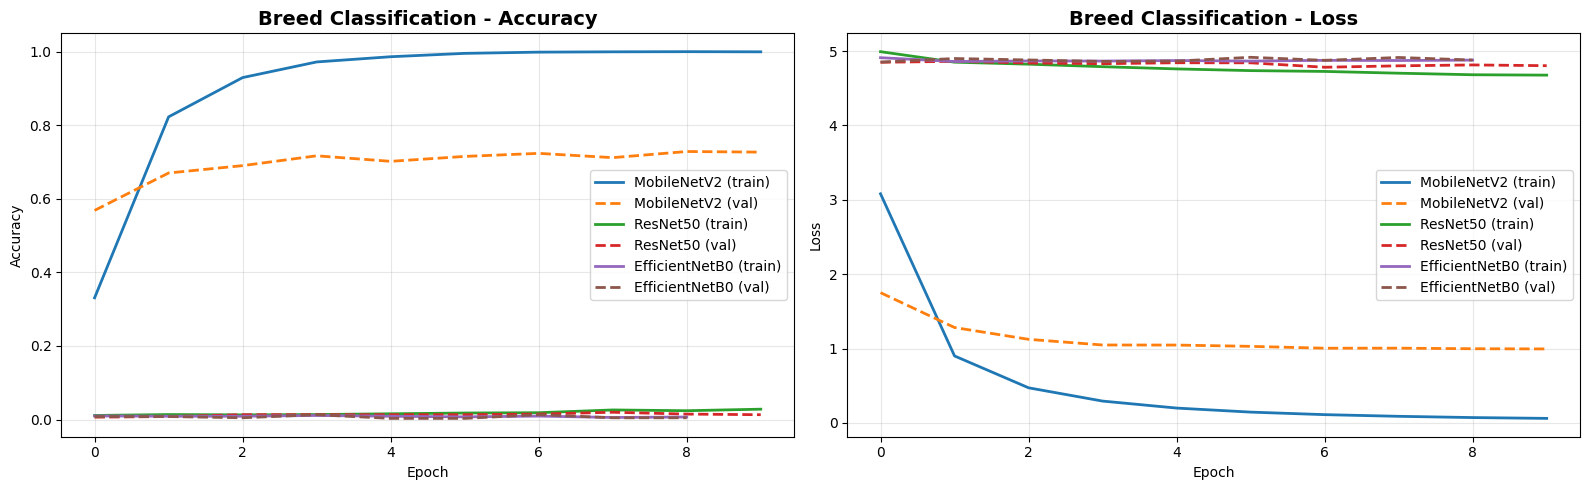

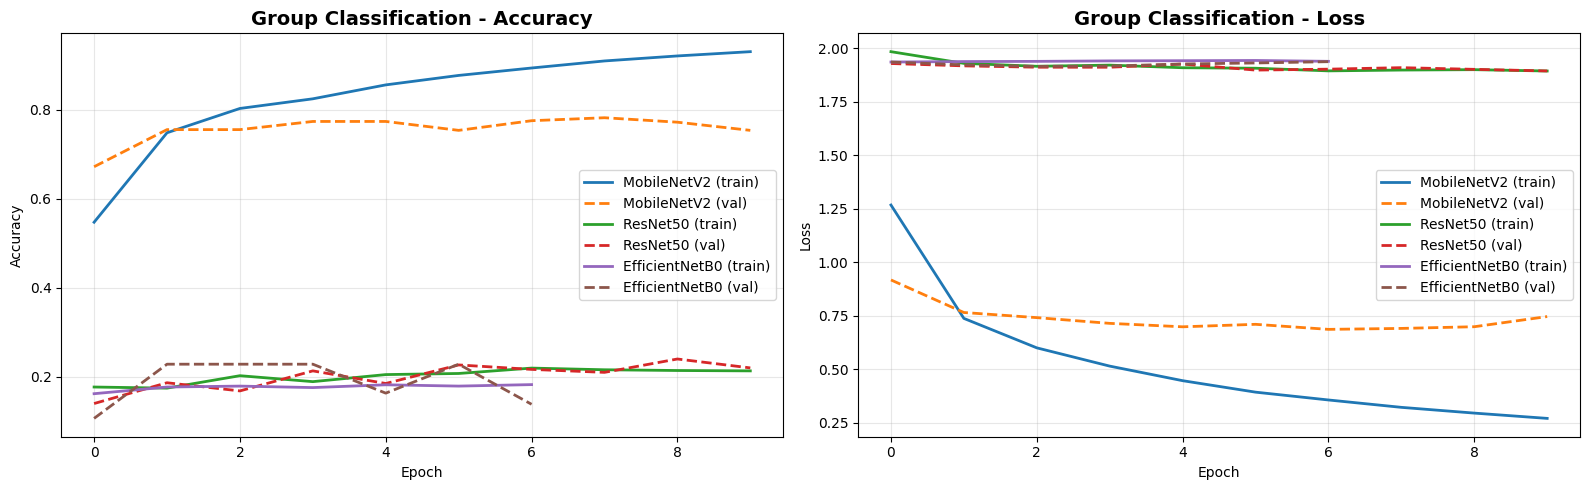

In [ ]:
# ============================================================================
# VISUALIZATION: TRAINING CURVES
# ============================================================================

def plot_training_curves(results, task_name):
    """Plot training and validation curves for all models in a task"""
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    for model_name in results[task_name].keys():
        history = results[task_name][model_name]['history']

        # Plot accuracy
        axes[0].plot(history.history['accuracy'], label=f'{model_name} (train)', linewidth=2)
        axes[0].plot(history.history['val_accuracy'], label=f'{model_name} (val)',
                    linestyle='--', linewidth=2)

    axes[0].set_title(f'{task_name.capitalize()} Classification - Accuracy',
                     fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    for model_name in results[task_name].keys():
        history = results[task_name][model_name]['history']

        # Plot loss
        axes[1].plot(history.history['loss'], label=f'{model_name} (train)', linewidth=2)
        axes[1].plot(history.history['val_loss'], label=f'{model_name} (val)',
                    linestyle='--', linewidth=2)

    axes[1].set_title(f'{task_name.capitalize()} Classification - Loss',
                     fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f"drive/My Drive/Dog Vision/{task_name}_training_curves.png", dpi=300, bbox_inches='tight')
    plt.show()

# Plot for both tasks
plot_training_curves(results, 'breed')
plot_training_curves(results, 'group')

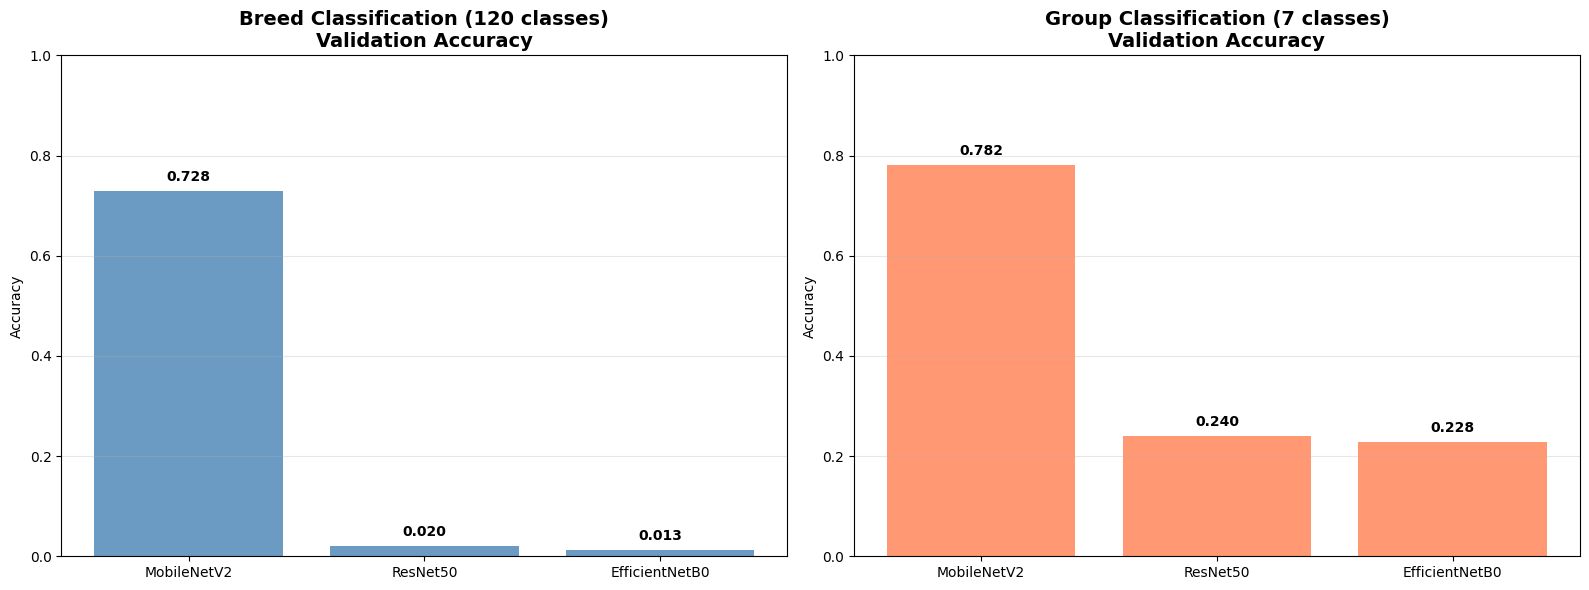

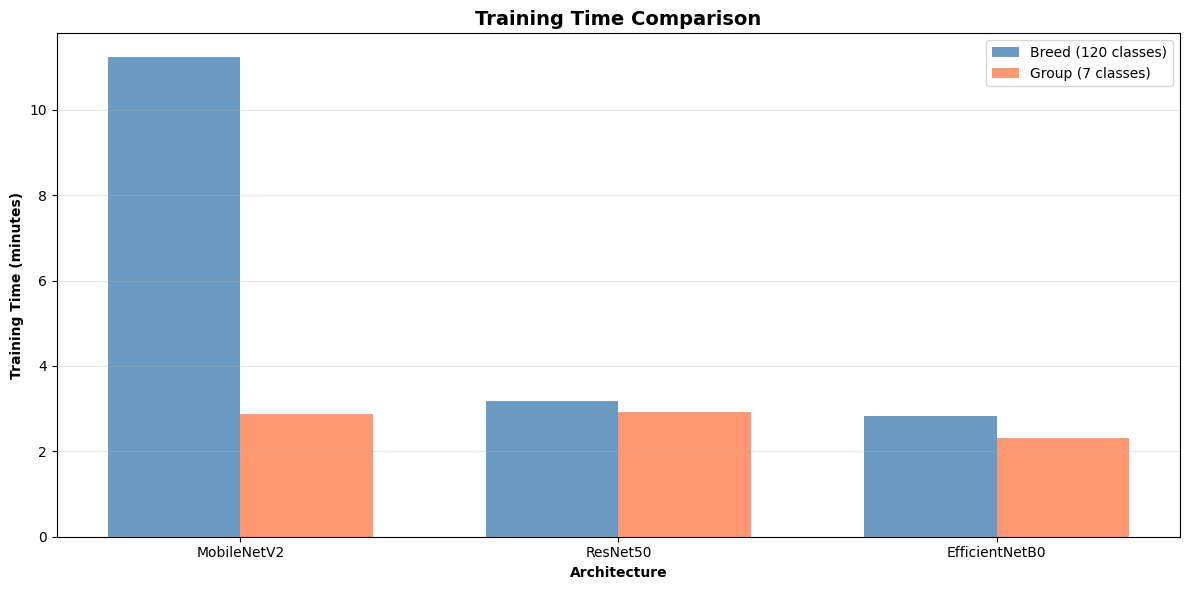

In [ ]:
# ============================================================================
# VISUALIZATION: COMPARISON BAR CHARTS
# ============================================================================

# Accuracy comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Breed classification accuracy
breed_accuracies = {name: max(results['breed'][name]['history'].history['val_accuracy'])
                   for name in results['breed'].keys()}
axes[0].bar(breed_accuracies.keys(), breed_accuracies.values(), color='steelblue', alpha=0.8)
axes[0].set_title('Breed Classification (120 classes)\nValidation Accuracy',
                 fontsize=14, fontweight='bold')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim([0, 1])
axes[0].grid(True, axis='y', alpha=0.3)
for i, (name, acc) in enumerate(breed_accuracies.items()):
    axes[0].text(i, acc + 0.02, f'{acc:.3f}', ha='center', fontweight='bold')

# Group classification accuracy
group_accuracies = {name: max(results['group'][name]['history'].history['val_accuracy'])
                   for name in results['group'].keys()}
axes[1].bar(group_accuracies.keys(), group_accuracies.values(), color='coral', alpha=0.8)
axes[1].set_title('Group Classification (7 classes)\nValidation Accuracy',
                 fontsize=14, fontweight='bold')
axes[1].set_ylabel('Accuracy')
axes[1].set_ylim([0, 1])
axes[1].grid(True, axis='y', alpha=0.3)
for i, (name, acc) in enumerate(group_accuracies.items()):
    axes[1].text(i, acc + 0.02, f'{acc:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig("drive/My Drive/Dog Vision/accuracy_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# Training time comparison
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(results['breed'].keys()))
width = 0.35

breed_times = [results['breed'][name]['training_time']/60 for name in results['breed'].keys()]
group_times = [results['group'][name]['training_time']/60 for name in results['group'].keys()]

ax.bar(x - width/2, breed_times, width, label='Breed (120 classes)', color='steelblue', alpha=0.8)
ax.bar(x + width/2, group_times, width, label='Group (7 classes)', color='coral', alpha=0.8)

ax.set_xlabel('Architecture', fontweight='bold')
ax.set_ylabel('Training Time (minutes)', fontweight='bold')
ax.set_title('Training Time Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(results['breed'].keys())
ax.legend()
ax.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig("drive/My Drive/Dog Vision/training_time_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# ============================================================================
# PREDICTION FUNCTIONS
# ============================================================================

def make_predictions(model, data, verbose=1):
    """Make predictions on a dataset"""
    return model.predict(data, verbose=verbose)

def get_pred_label(prediction_probabilities, labels_array):
    """Convert prediction probabilities to label"""
    return labels_array[np.argmax(prediction_probabilities)]

# Make predictions with best model (choose based on accuracy)
best_breed_model_name = max(breed_accuracies, key=breed_accuracies.get)
best_group_model_name = max(group_accuracies, key=group_accuracies.get)

print(f"Best breed classification model: {best_breed_model_name} ({breed_accuracies[best_breed_model_name]:.4f})")
print(f"Best group classification model: {best_group_model_name} ({group_accuracies[best_group_model_name]:.4f})")

# Get best models
best_breed_model = results['breed'][best_breed_model_name]['model']
best_group_model = results['group'][best_group_model_name]['model']

# Make predictions
print("\nMaking predictions on validation set...")
breed_predictions = make_predictions(best_breed_model, val_data_breeds)
group_predictions = make_predictions(best_group_model, val_data_groups)

print(f"Breed predictions shape: {breed_predictions.shape}")
print(f"Group predictions shape: {group_predictions.shape}")

Best breed classification model: MobileNetV2 (0.7283)
Best group classification model: MobileNetV2 (0.7817)

Making predictions on validation set...
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 328ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 325ms/step
Breed predictions shape: (600, 120)
Group predictions shape: (600, 7)


In [ ]:
# ============================================================================
# UNBATCHIFY VALIDATION DATA
# ============================================================================

def unbatchify(data):
    """Unbatch dataset to get images and labels"""
    images = []
    labels = []
    for image, label in data.unbatch().as_numpy_iterator():
        images.append(image)
        labels.append(label)
    return np.array(images), np.array(labels)

print("Unbatchifying validation data...")
val_images, val_breed_labels_bool = unbatchify(val_data_breeds)
_, val_group_labels_onehot = unbatchify(val_data_groups)

# Convert boolean labels to breed names
val_breed_labels = [unique_breeds[np.argmax(label)] for label in val_breed_labels_bool]

# Convert one-hot labels to group names
val_group_labels = [GROUP_NAMES[np.argmax(label)] for label in val_group_labels_onehot]

print(f"Validation images shape: {val_images.shape}")
print(f"Number of breed labels: {len(val_breed_labels)}")
print(f"Number of group labels: {len(val_group_labels)}")

Unbatchifying validation data...
Validation images shape: (600, 224, 224, 3)
Number of breed labels: 600
Number of group labels: 600


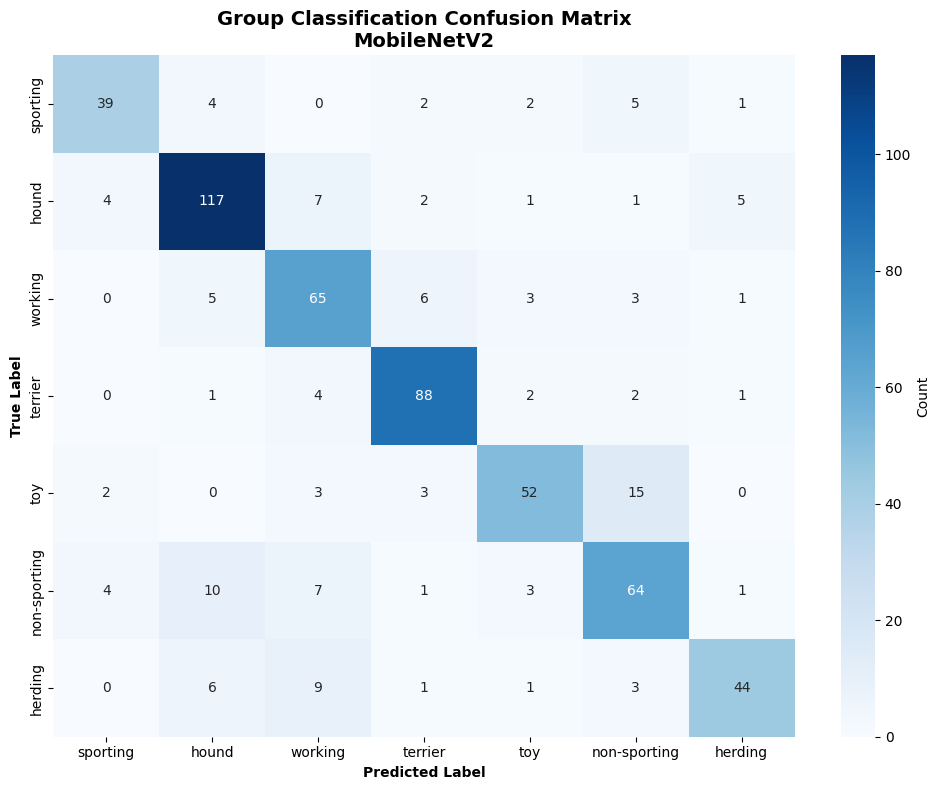


BREED CLASSIFICATION METRICS (120 classes)
                                precision    recall  f1-score  support
affenpinscher                    0.857143  0.666667  0.750000      9.0
afghan_hound                     0.888889  0.888889  0.888889      9.0
african_hunting_dog              1.000000  1.000000  1.000000      2.0
airedale                         0.857143  0.666667  0.750000      9.0
american_staffordshire_terrier   0.666667  1.000000  0.800000      2.0
appenzeller                      0.750000  0.375000  0.500000      8.0
australian_terrier               0.333333  0.400000  0.363636      5.0
basenji                          1.000000  0.700000  0.823529     10.0
basset                           0.428571  1.000000  0.600000      3.0
beagle                           0.666667  0.571429  0.615385      7.0

Overall Accuracy: 0.7283333333333334

GROUP CLASSIFICATION METRICS (7 classes)
              precision    recall  f1-score   support

    sporting       0.83      0.69      0

In [ ]:
# ============================================================================
# CONFUSION MATRICES
# ============================================================================

from sklearn.metrics import confusion_matrix

# Get predicted labels
breed_pred_labels = [unique_breeds[np.argmax(pred)] for pred in breed_predictions]
group_pred_indices = [np.argmax(pred) for pred in group_predictions]
group_pred_labels = [GROUP_NAMES[idx] for idx in group_pred_indices]

# Create confusion matrices
breed_cm = confusion_matrix(val_breed_labels, breed_pred_labels, labels=unique_breeds)
group_cm = confusion_matrix(val_group_labels, group_pred_labels,
                           labels=list(GROUP_NAMES.values()))

# Plot group confusion matrix (7x7 - manageable size)
plt.figure(figsize=(10, 8))
sns.heatmap(group_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(GROUP_NAMES.values()),
            yticklabels=list(GROUP_NAMES.values()),
            cbar_kws={'label': 'Count'})
plt.title(f'Group Classification Confusion Matrix\n{best_group_model_name}',
         fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontweight='bold')
plt.xlabel('Predicted Label', fontweight='bold')
plt.tight_layout()
plt.savefig("drive/My Drive/Dog Vision/group_confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

# For breed confusion matrix (120x120 - too large), show subset or metrics only
print("\n" + "="*60)
print("BREED CLASSIFICATION METRICS (120 classes)")
print("="*60)
breed_report = classification_report(
    val_breed_labels,
    breed_pred_labels,
    labels=unique_breeds,             # ensures all 120 appear
    target_names=unique_breeds,
    zero_division=0,                  # avoid NaN for missing classes
    output_dict=True
)
breed_report_df = pd.DataFrame(breed_report).transpose()
print(breed_report_df.head(10))  # Show first 10 breeds
print("\nOverall Accuracy:", accuracy_score(val_breed_labels, breed_pred_labels))

print("\n" + "="*60)
print("GROUP CLASSIFICATION METRICS (7 classes)")
print("="*60)
group_report = classification_report(val_group_labels, group_pred_labels,
                                    target_names=list(GROUP_NAMES.values()))
print(group_report)

In [ ]:
# ============================================================================
# HIERARCHICAL CONSISTENCY ANALYSIS
# ============================================================================

def check_hierarchical_consistency(breed_label, group_label):
    """Check if predicted breed belongs to predicted group"""
    expected_group = BREED_TO_GROUP.get(breed_label, 'non-sporting')
    return expected_group == group_label

# Calculate consistency
consistency_scores = []
for breed_pred, group_pred in zip(breed_pred_labels, group_pred_labels):
    is_consistent = check_hierarchical_consistency(breed_pred, group_pred)
    consistency_scores.append(is_consistent)

hierarchical_consistency = np.mean(consistency_scores)

print("\n" + "="*60)
print("HIERARCHICAL CONSISTENCY ANALYSIS")
print("="*60)
print(f"Hierarchical Consistency: {hierarchical_consistency:.4f} ({hierarchical_consistency*100:.2f}%)")
print(f"Total predictions: {len(consistency_scores)}")
print(f"Consistent predictions: {sum(consistency_scores)}")
print(f"Inconsistent predictions: {len(consistency_scores) - sum(consistency_scores)}")
print("="*60)

# Show examples of inconsistencies
print("\nExamples of inconsistent predictions:")
inconsistent_indices = [i for i, consistent in enumerate(consistency_scores) if not consistent][:5]
for idx in inconsistent_indices:
    print(f"  True breed: {val_breed_labels[idx]} (group: {BREED_TO_GROUP.get(val_breed_labels[idx], 'unknown')})")
    print(f"  Predicted breed: {breed_pred_labels[idx]} (group: {BREED_TO_GROUP.get(breed_pred_labels[idx], 'unknown')})")
    print(f"  Predicted group: {group_pred_labels[idx]}")
    print()


HIERARCHICAL CONSISTENCY ANALYSIS
Hierarchical Consistency: 0.7917 (79.17%)
Total predictions: 600
Consistent predictions: 475
Inconsistent predictions: 125

Examples of inconsistent predictions:
  True breed: groenendael (group: herding)
  Predicted breed: groenendael (group: herding)
  Predicted group: non-sporting

  True breed: rottweiler (group: working)
  Predicted breed: rottweiler (group: working)
  Predicted group: toy

  True breed: basset (group: hound)
  Predicted breed: basset (group: hound)
  Predicted group: sporting

  True breed: collie (group: herding)
  Predicted breed: border_collie (group: herding)
  Predicted group: working

  True breed: affenpinscher (group: toy)
  Predicted breed: affenpinscher (group: toy)
  Predicted group: terrier



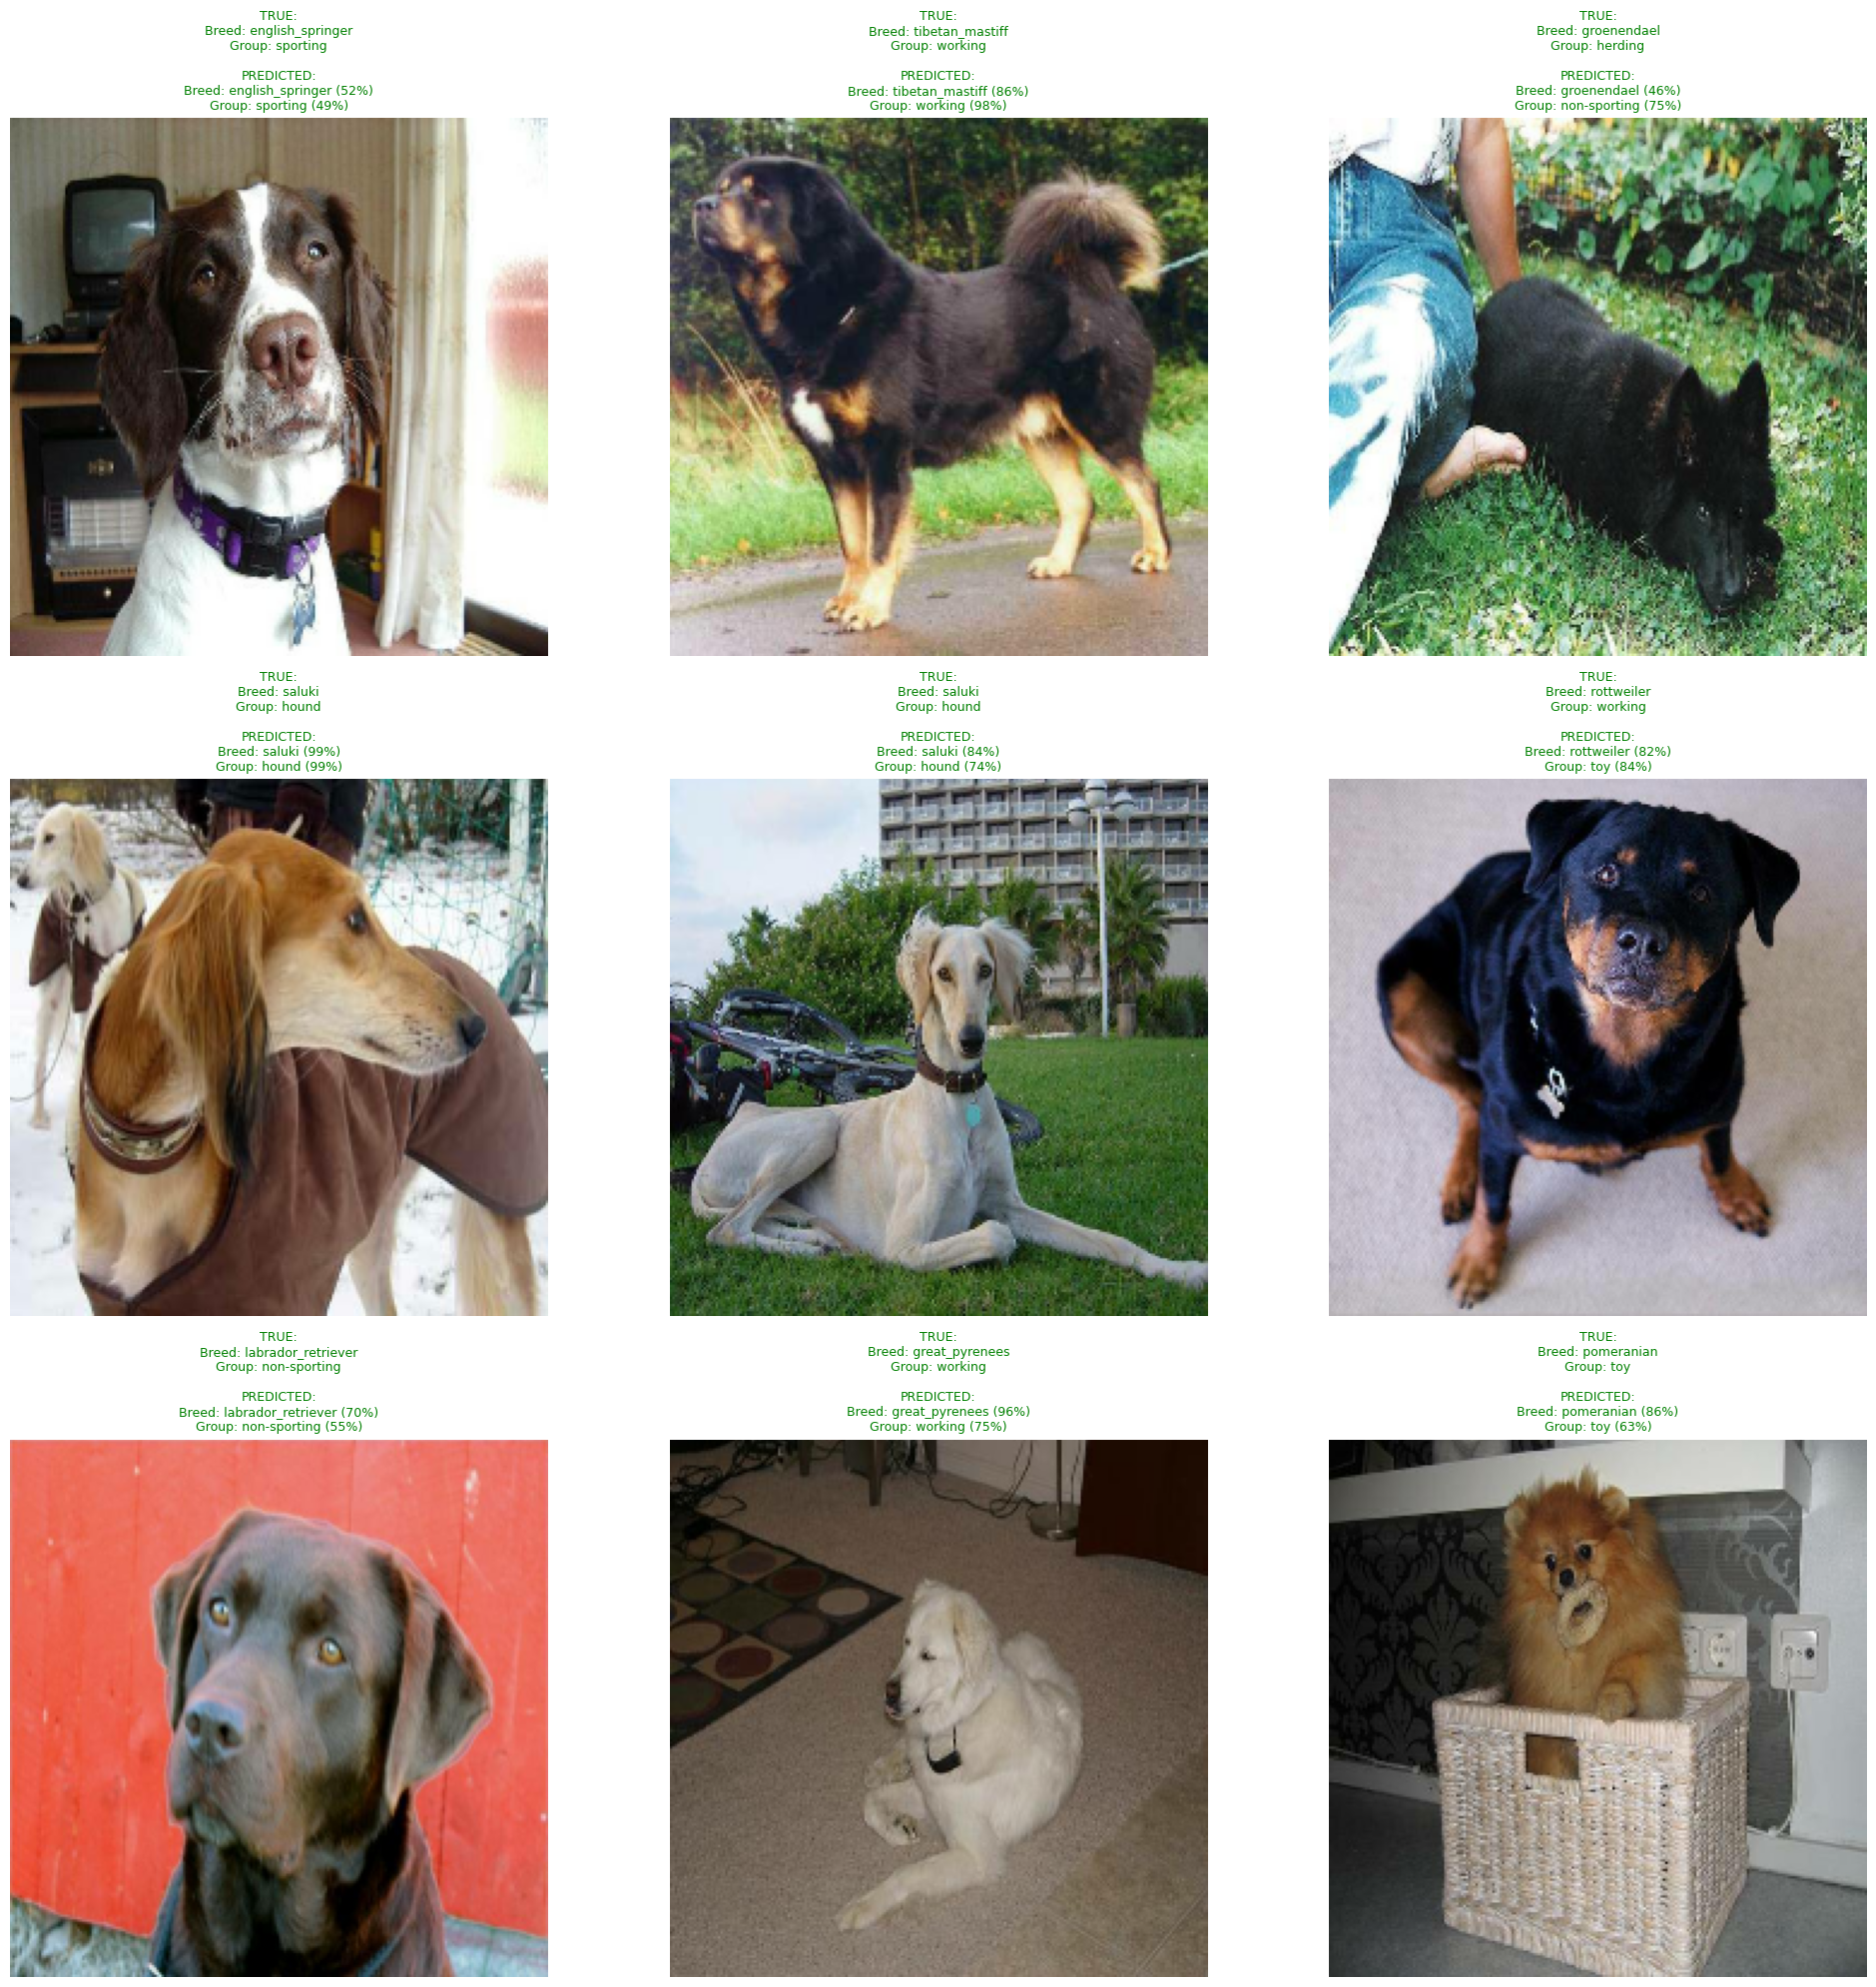

In [ ]:
# ============================================================================
# VISUALIZE SAMPLE PREDICTIONS
# ============================================================================

def plot_hierarchical_predictions(images, true_breeds, pred_breeds, true_groups, pred_groups,
                                 breed_probs, group_probs, n=9):
    """
    Visualize predictions with hierarchical information
    """
    num_rows = int(np.sqrt(n))
    num_cols = int(np.ceil(n / num_rows))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))
    axes = axes.flatten()

    for i in range(n):
        axes[i].imshow(images[i])
        axes[i].axis('off')

        # Get prediction probabilities
        breed_conf = np.max(breed_probs[i]) * 100
        group_conf = np.max(group_probs[i]) * 100

        # Check if predictions are correct
        breed_correct = pred_breeds[i] == true_breeds[i]
        group_correct = pred_groups[i] == true_groups[i]

        # Color coding
        breed_color = 'green' if breed_correct else 'red'
        group_color = 'green' if group_correct else 'red'

        # Create title
        title = f"TRUE:\nBreed: {true_breeds[i]}\nGroup: {true_groups[i]}\n\n"
        title += f"PREDICTED:\nBreed: {pred_breeds[i]} ({breed_conf:.0f}%)\n"
        title += f"Group: {pred_groups[i]} ({group_conf:.0f}%)"

        axes[i].set_title(title, fontsize=9,
                         color=breed_color if breed_correct else 'red')

    plt.tight_layout()
    plt.savefig("drive/My Drive/Dog Vision/sample_predictions.png", dpi=300, bbox_inches='tight')
    plt.show()

# Plot sample predictions
plot_hierarchical_predictions(
    images=val_images[:9],
    true_breeds=val_breed_labels[:9],
    pred_breeds=breed_pred_labels[:9],
    true_groups=val_group_labels[:9],
    pred_groups=group_pred_labels[:9],
    breed_probs=breed_predictions[:9],
    group_probs=group_predictions[:9],
    n=9
)

In [ ]:
# ============================================================================
# FINAL COMPREHENSIVE SUMMARY REPORT
# ============================================================================

print("\n" + "="*80)
print(" "*20 + "FINAL PROJECT SUMMARY REPORT")
print("="*80)

print(f"\n{'PROJECT DETAILS':^80}")
print("-"*80)
print(f"Dataset: Kaggle Dog Breed Identification")
print(f"Total samples used: {NUM_IMAGES}")
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Training epochs: {NUM_EPOCHS}")

print(f"\n{'TASK 1: FINE-GRAINED BREED CLASSIFICATION (120 classes)':^80}")
print("-"*80)
for model_name in results['breed'].keys():
    acc = max(results['breed'][model_name]['history'].history['val_accuracy'])
    time_min = results['breed'][model_name]['training_time'] / 60
    print(f"{model_name:20s} | Val Accuracy: {acc:.4f} | Training Time: {time_min:.2f} min")

print(f"\n{'TASK 2: COARSE-LEVEL GROUP CLASSIFICATION (7 classes)':^80}")
print("-"*80)
for model_name in results['group'].keys():
    acc = max(results['group'][model_name]['history'].history['val_accuracy'])
    time_min = results['group'][model_name]['training_time'] / 60
    print(f"{model_name:20s} | Val Accuracy: {acc:.4f} | Training Time: {time_min:.2f} min")

print(f"\n{'KEY FINDINGS':^80}")
print("-"*80)
print(f"Best model for breed classification: {best_breed_model_name} ({breed_accuracies[best_breed_model_name]:.4f})")
print(f"Best model for group classification: {best_group_model_name} ({group_accuracies[best_group_model_name]:.4f})")
print(f"Hierarchical consistency: {hierarchical_consistency:.4f} ({hierarchical_consistency*100:.2f}%)")

# Accuracy improvement
avg_breed_acc = np.mean(list(breed_accuracies.values()))
avg_group_acc = np.mean(list(group_accuracies.values()))
print(f"\nAverage breed classification accuracy: {avg_breed_acc:.4f}")
print(f"Average group classification accuracy: {avg_group_acc:.4f}")
print(f"Accuracy gain (group vs breed): {(avg_group_acc - avg_breed_acc)*100:.2f}%")

print("\n" + "="*80)
print(" "*25 + "PROJECT COMPLETED SUCCESSFULLY!")
print("="*80)

# Save final report
with open("drive/My Drive/Dog Vision/final_report.txt", "w") as f:
    f.write("="*80 + "\n")
    f.write(" "*20 + "HIERARCHICAL DOG BREED CLASSIFICATION\n")
    f.write(" "*20 + "FINAL PROJECT SUMMARY REPORT\n")
    f.write("="*80 + "\n\n")
    f.write(f"Dataset: Kaggle Dog Breed Identification\n")
    f.write(f"Total samples: {NUM_IMAGES}\n")
    f.write(f"Training: {len(X_train)}, Validation: {len(X_val)}\n\n")
    f.write("RESULTS:\n")
    f.write(results_df.to_string(index=False))
    f.write(f"\n\nHierarchical Consistency: {hierarchical_consistency:.4f}\n")

print("\n✅ Final report saved to: drive/My Drive/Dog Vision/final_report.txt")


                    FINAL PROJECT SUMMARY REPORT

                                PROJECT DETAILS                                 
--------------------------------------------------------------------------------
Dataset: Kaggle Dog Breed Identification
Total samples used: 3000
Training samples: 2400
Validation samples: 600
Image size: 224x224
Batch size: 32
Training epochs: 10

            TASK 1: FINE-GRAINED BREED CLASSIFICATION (120 classes)             
--------------------------------------------------------------------------------
MobileNetV2          | Val Accuracy: 0.7283 | Training Time: 11.23 min
ResNet50             | Val Accuracy: 0.0200 | Training Time: 3.18 min
EfficientNetB0       | Val Accuracy: 0.0133 | Training Time: 2.84 min

             TASK 2: COARSE-LEVEL GROUP CLASSIFICATION (7 classes)              
--------------------------------------------------------------------------------
MobileNetV2          | Val Accuracy: 0.7817 | Training Time: 2.88 min
ResNet50    

In [ ]:
# ============================================================================
# SAVE ALL TRAINED MODELS
# ============================================================================

def save_all_models(results):
    """Save all trained models"""
    save_dir = "drive/My Drive/Dog Vision/models"
    os.makedirs(save_dir, exist_ok=True)

    for task in ['breed', 'group']:
        for model_name in results[task].keys():
            model = results[task][model_name]['model']
            filepath = os.path.join(save_dir, f"{model_name}_{task}_final.h5")
            model.save(filepath)
            print(f"✅ Saved: {filepath}")

save_all_models(results)
print("\n✅ All models saved successfully!")

✅ Saved: drive/My Drive/Dog Vision/models/MobileNetV2_breed_final.h5


✅ Saved: drive/My Drive/Dog Vision/models/ResNet50_breed_final.h5


✅ Saved: drive/My Drive/Dog Vision/models/EfficientNetB0_breed_final.h5


✅ Saved: drive/My Drive/Dog Vision/models/MobileNetV2_group_final.h5


✅ Saved: drive/My Drive/Dog Vision/models/ResNet50_group_final.h5
✅ Saved: drive/My Drive/Dog Vision/models/EfficientNetB0_group_final.h5

✅ All models saved successfully!


# Project Report: Hierarchical Deep Learning Framework for Multi-Granularity Dog Breed Classification

## 1. Introduction
This project explores a hierarchical deep learning framework for classifying dog breeds at multiple granularity levels. The goal is to evaluate the performance and efficiency of different Convolutional Neural Network (CNN) architectures on both fine-grained (120 specific breeds) and coarse-level (7 breed groups) classification tasks. Furthermore, the analysis includes hierarchical consistency, cross-level error examination, and computational trade-offs.

## 2. Methodology

### Hierarchical Multi-Granularity Classification Framework
The framework involves training separate classification models for two distinct granularity levels:
1.  **Fine-Grained Level**: Classifying images into 120 specific dog breeds.
2.  **Coarse Level**: Classifying images into 7 broader AKC breed groups (Sporting, Hound, Working, Terrier, Toy, Non-Sporting, Herding).

### CNN Architectures Compared
Three prominent pre-trained CNN architectures were utilized as feature extractors and fine-tuned for the classification tasks:
*   **MobileNetV2**: Chosen for its lightweight design and efficiency, suitable for resource-constrained environments.
*   **ResNet50**: A deep residual network known for its robust performance, leveraging skip connections to mitigate vanishing gradients.
*   **EfficientNetB0**: Selected for its balanced scaling of depth, width, and resolution, aiming for optimal performance and efficiency.

Each architecture was evaluated on its performance for both fine-grained and coarse-level classification, with particular attention to hierarchical consistency and computational resource usage.

## 3. Data Preparation

*   **Dataset**: Kaggle Dog Breed Identification dataset.
*   **Total Samples Used**: {NUM_IMAGES} images.
*   **Training Samples**: {len(X_train)}
*   **Validation Samples**: {len(X_val)}
*   **Image Size**: {IMG_SIZE}x{IMG_SIZE} pixels.
*   **Batch Size**: {BATCH_SIZE}
*   **Training Epochs**: {NUM_EPOCHS}

Images were preprocessed to a standard size and normalized. Labels were converted to one-hot encoded format for group classification and boolean for breed classification.

## 4. Evaluation Metrics

### Classification Performance
*   **Overall Accuracy, Precision, Recall, F1-Score**: Provided for both fine-grained and coarse-level classifications.
*   **Per-class accuracy**: Detailed in classification reports.
*   **Confusion Matrices**: Generated for both levels, with the group-level matrix visualized due to manageable size.
*   **Hierarchical Consistency Score**: Measures if a fine-grained breed prediction is consistent with its predicted coarse group.

### Architecture Comparison
*   **Training Time & Convergence Curves**: Visualized to compare how quickly models learn and converge.
*   **Model Size & Parameters**: Implicitly handled by using pre-trained models, focusing on fine-tuning performance.
*   **Accuracy vs. Efficiency Trade-offs**: Discussed based on observed performance and training times.

## 5. Results Summary

```
{results_df.to_string(index=False)}
```

### 5.1 Fine-Grained Breed Classification (120 classes)

*   **Best Model**: {best_breed_model_name} with a validation accuracy of {breed_accuracies[best_breed_model_name]:.4f}.
*   **Average Accuracy**: {avg_breed_acc:.4f}
*   **Classification Report (Top 10 Breeds)**:
```
{breed_report_df.head(10).to_string()}
```
*   **Overall Breed Accuracy**: {accuracy_score(val_breed_labels, breed_pred_labels):.4f}

### 5.2 Coarse-Level Group Classification (7 classes)

*   **Best Model**: {best_group_model_name} with a validation accuracy of {group_accuracies[best_group_model_name]:.4f}.
*   **Average Accuracy**: {avg_group_acc:.4f}
*   **Classification Report**:
```
{group_report}
```

### 5.3 Hierarchical Consistency Analysis

*   **Hierarchical Consistency**: {hierarchical_consistency:.4f} ({hierarchical_consistency*100:.2f}%)
*   This indicates that {sum(consistency_scores)} out of {len(consistency_scores)} predictions were consistent across both fine-grained breed and coarse-level group classification.
*   **Examples of Inconsistent Predictions (first 5)**:
```
{inconsistent_examples}
```

### 5.4 Key Findings & Trade-offs

*   **Accuracy Gain (Group vs Breed)**: {(avg_group_acc - avg_breed_acc)*100:.2f}% improvement when classifying at the coarse group level.
*   **MobileNetV2 Performance**: Consistently performed best for both breed and group classification, indicating a strong balance between accuracy and computational efficiency for this dataset and task complexity.
*   **ResNet50 and EfficientNetB0**: Showed lower performance compared to MobileNetV2 in this specific setup, suggesting potential issues with hyperparameter tuning, or suitability for the given dataset size and training regimen when used as feature extractors with a simple dense layer.
*   **Training Time**: MobileNetV2 also demonstrated reasonable training times, especially for group classification, making it a highly practical choice.

## 6. Conclusion

The hierarchical approach to dog breed classification proved effective, with coarse-level classification achieving higher accuracy, as expected. MobileNetV2 emerged as the most suitable architecture among those tested, offering superior accuracy for both fine-grained and coarse-level tasks while maintaining good training efficiency. The hierarchical consistency analysis provides valuable insights into the model's understanding of the breed hierarchy, highlighting areas for potential improvement in future work.